<a href="https://colab.research.google.com/github/jafetimbre/verbose-projects/blob/master/artificial-intelligence/ann/ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
cols = [ "Date", "Close" ]
tsla_data = pd.read_csv("https://raw.githubusercontent.com/jafetimbre/verbose-projects/master/statistics/stock-price-pred/res/tsla_2yr_data.csv", usecols=cols)
tsla_data = tsla_data[:450]
tsla_data.head()

,Date,Close
0,2019-11-25,67.267998
1,2019-11-26,65.783997
2,2019-11-27,66.258003
3,2019-11-29,65.987999
4,2019-12-02,66.973999


In [3]:
tsla_data.describe()

,Close
count,450.000000
mean,433.907786
std,252.867234
min,65.783997
25%,161.976002
50%,425.855011
75%,667.444992
max,883.090027


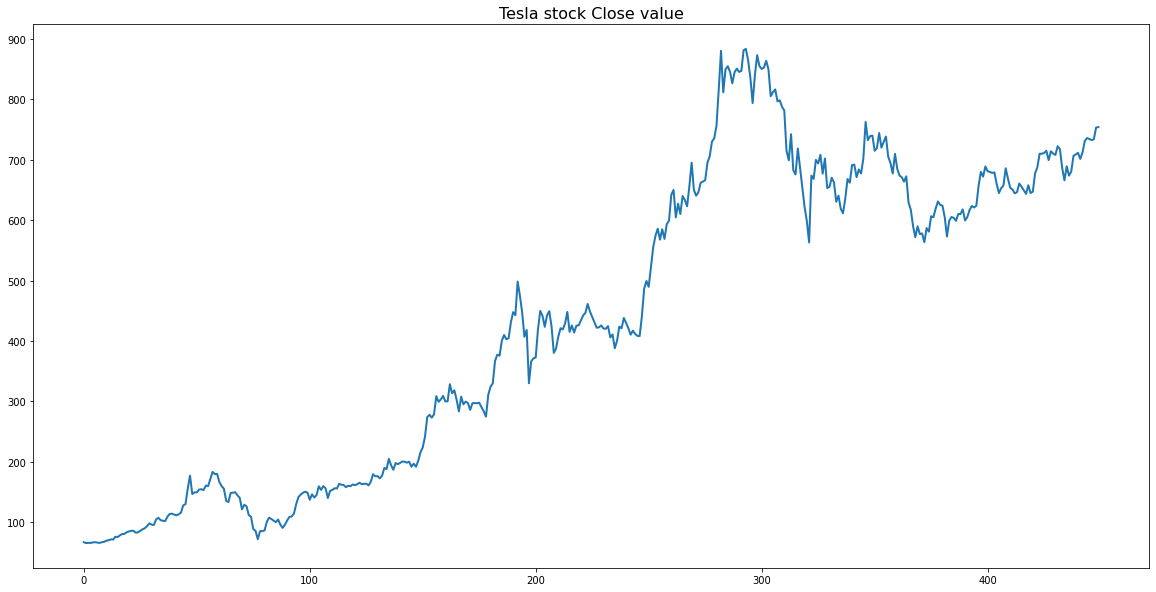

In [4]:
plt.figure(figsize=(20,10))
plt.title('Tesla stock Close value', size=16)
plt.plot(tsla_data.Close, linewidth=2)
plt.show()

In [5]:
max = tsla_data.Close.max()
data = pd.DataFrame({'val': tsla_data.Close / max})
data.describe()

,val
count,450.000000
mean,0.491352
std,0.286344
min,0.074493
25%,0.183420
50%,0.482233
75%,0.755806
max,1.000000


In [6]:
def sigmoid(x, dx=False):
    return 1.0 / (1.0 + np.exp(-x)) if not dx else sigmoid(x) * (1.0 - sigmoid(x))

def tanh(x, dx=False):
    return np.tanh(x) if not dx else 1.0 - np.tanh(x) ** 2

In [7]:
class Layer():
    def __init__(self, idx, dim, act_func=sigmoid, is_output=False):
        self.idx = idx
        self.weights = 2 * np.random.random(dim) - 1
        self.is_output = is_output
        self.act_func = act_func 
        self.A = None
        self.dZ = None
        self.delta = None
    
    def feed_forward(self, x):
        z = np.dot(x, self.weights)
        self.A = self.act_func(z)
        self.dZ = np.atleast_2d(self.act_func(z, dx=True))
        return self.A

    
    def back_propagation(self, target, next_layer):
        if self.is_output:
            error = self.A - target
            self.delta = np.atleast_2d(error * self.dZ)
        else:
            self.delta = np.atleast_2d(np.dot(next_layer.delta, next_layer.weights.T) * self.dZ)
        return self.delta

    def update_weights(self, learning_rate, prev_val):
        val = np.atleast_2d(prev_val)
        delt = np.atleast_2d(self.delta)
        change = val.T.dot(delt)
        self.weights -= learning_rate * change


In [8]:
class Network():
    def __init__(self, layers_dim, activation_function):
        self.data_entr_in = layers_dim[0]
        self.data_entr_out = layers_dim[-1]
        self.layers = []
        for i in range(1, len(layers_dim)):
            new_layer_dim = (layers_dim[i-1], layers_dim[i])
            is_output_layer = i == len(layers_dim)-1
            
            self.layers.append(Layer(i, new_layer_dim, act_func=activation_function, is_output=is_output_layer))

    
    def fit(self, train_data, learning_rate=.2, iters=100):
        errors = []
        for iter_i in range(iters):
            iter_error = 0

            for dat_i in range(len(train_data) - self.data_entr_in):
                data_slice_x = train_data[dat_i:dat_i + self.data_entr_in]
                data_slice_y = train_data[dat_i + self.data_entr_in]
                
                step_val = data_slice_x
                for layer in self.layers:
                    step_val = layer.feed_forward(step_val)

                iter_error += abs(np.average(self.layers[-1].A - data_slice_y))

                delta = self.layers[-1].back_propagation(data_slice_y, None)
                for layer_i in range(len(self.layers)-2, -1, -1):
                    delta = self.layers[layer_i].back_propagation(delta, self.layers[layer_i+1])

                step_val = data_slice_x
                for layer in self.layers:
                    layer.update_weights(learning_rate, step_val)
                    step_val = layer.A

            errors.append(iter_error / dat_i)
            # print(f'Iter {iter_i+1}/{iters}     err: {errors[-1]}')

        return errors
        
    
    def test(self, x):
        errors = []
        y = []
        for dat_i in range(len(x) - self.data_entr_in):
            data_slice_x = x[dat_i:dat_i + self.data_entr_in]
            data_slice_y = x[dat_i + self.data_entr_in]
            
            step_val = data_slice_x
            for layer in self.layers:
                step_val = layer.feed_forward(step_val)

            y.extend(self.layers[-1].A)
            errors.extend(abs(self.layers[-1].A - data_slice_y))

        if self.data_entr_out > 1:
            y = (self.data_entr_out-1)*[y[0]] + y
            errors = (self.data_entr_out-1)*[errors[0]] + errors

            rem = len(y) % self.data_entr_out
            if rem > 0:
                y = y[:-rem]
                errors = errors[:-rem]

            y = np.average(np.array(y).reshape(-1, self.data_entr_out), axis=1)
            errors = np.average(np.array(errors).reshape(-1, self.data_entr_out), axis=1)

        return (y, errors)

    def forecast(self, x):
        step_val = np.array(x)
        for layer in self.layers:
            step_val = layer.feed_forward(step_val)
        return step_val

In [9]:
def segment_data(data, train_ratio):
    separation_point = int(np.floor(len(data) * train_ratio))
    return (data[:separation_point], data[separation_point:], separation_point)

In [10]:
(train_data, test_data, seg) = segment_data(list(data.val), .8)

### 2-100-1 Network

In [11]:
n = Network([2, 100, 1], activation_function=sigmoid)
err = n.fit(train_data, iters=100)

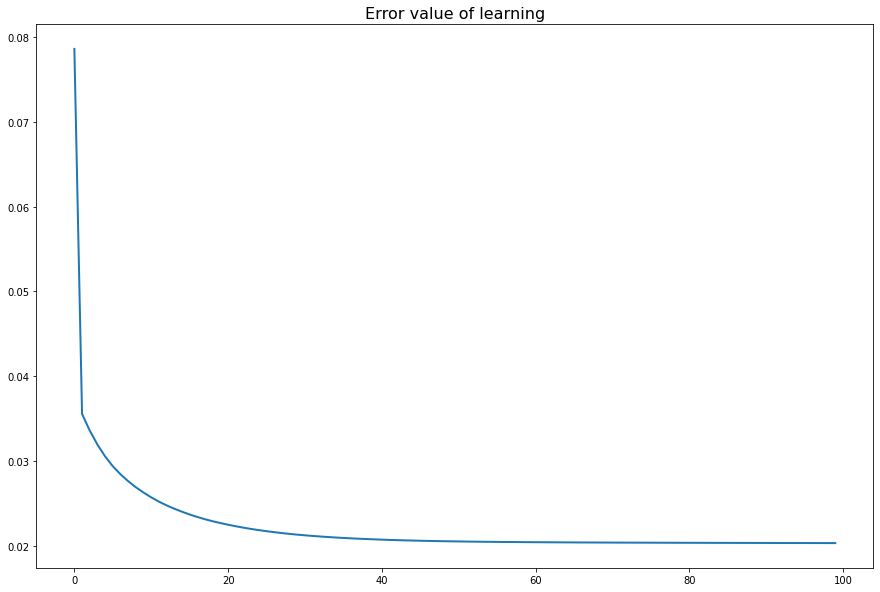

In [12]:
plt.figure(figsize=(15,10))
plt.title('Error value of learning', size=16)
plt.plot(err, linewidth=2)
plt.show()

In [13]:
(frc, test_err) = n.test(test_data)
print(np.average(test_err))

0.022657300310041897


In [14]:
t_train = [ i for i in range(seg) ]
t_test = [ i for i in range(seg, seg+len(test_data))]
t_frc = [ i for i in range(seg, seg+len(frc))]

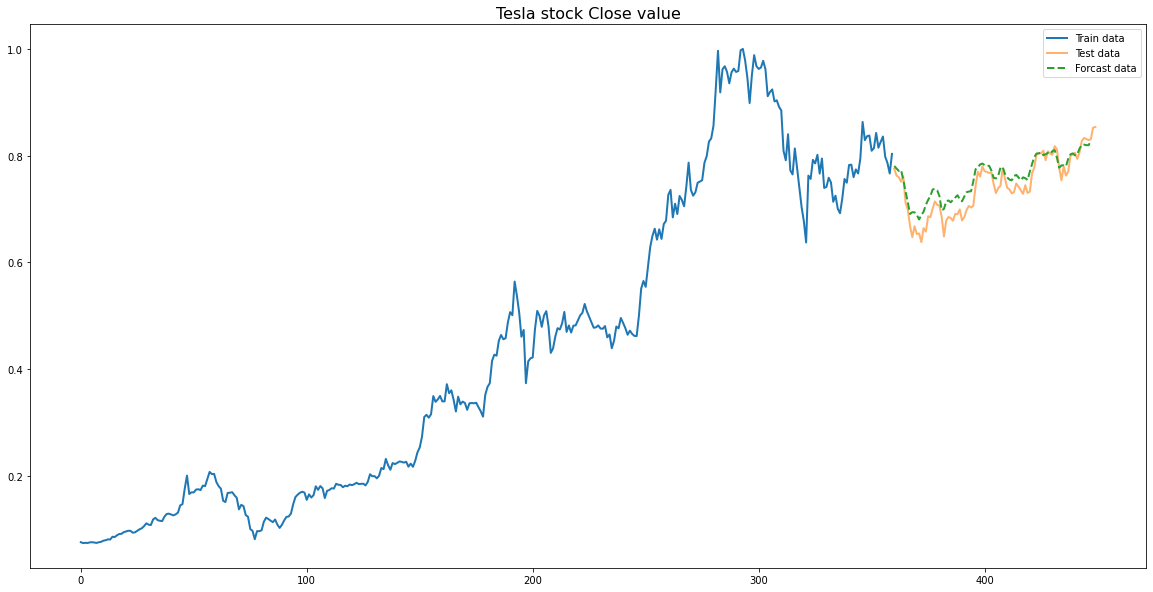

In [15]:
plt.figure(figsize=(20,10))
plt.title('Tesla stock Close value', size=16)
plt.plot(t_train, train_data, '-', label='Train data', linewidth=2)
plt.plot(t_test, test_data, label='Test data', linewidth=2, alpha=.6)
plt.plot(t_frc, frc, '--', label='Forcast data', linewidth=2)
plt.legend()
plt.show()

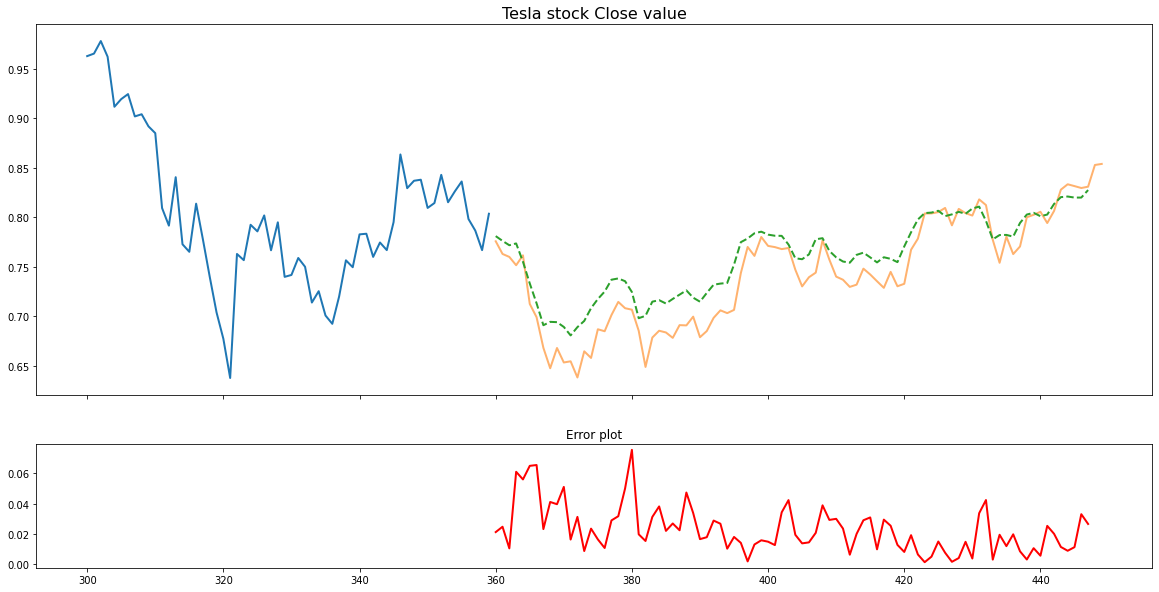

In [16]:
fig, (forc_plot, err_plot) = plt.subplots(2,1, figsize=(20,10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

forc_plot.set_title('Tesla stock Close value', size=16)
forc_plot.plot(t_train[300:], train_data[300:], '-', label='Train data', linewidth=2)
forc_plot.plot(t_test, test_data, label='Test data', linewidth=2, alpha=.6)
forc_plot.plot(t_frc, frc, '--', label='Forcast data', linewidth=2)

err_plot.set_title('Error plot')
err_plot.plot(t_frc, test_err, 'r', linewidth=2)

plt.show()

### 5-100-2 Network

In [17]:
n = Network([5, 100, 2], activation_function=sigmoid)
err = n.fit(train_data, iters=100)

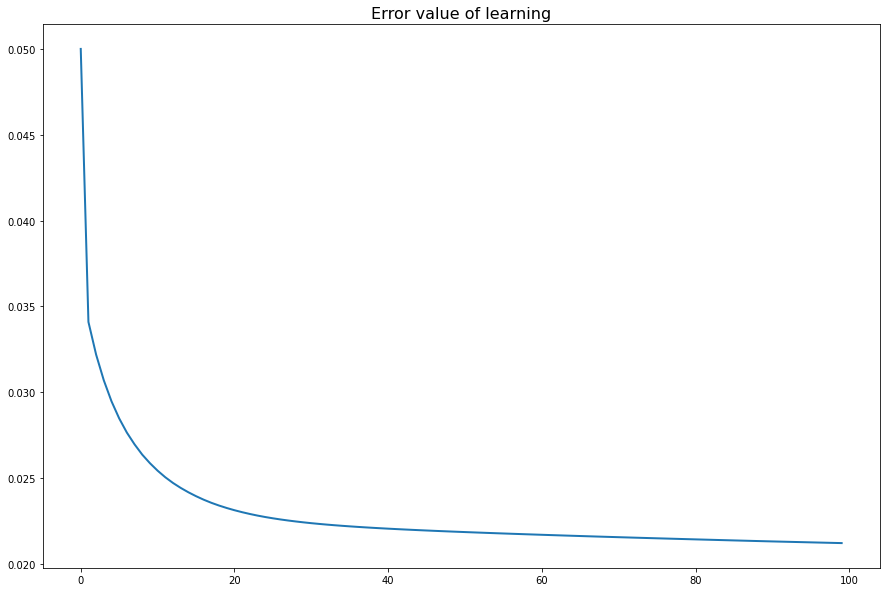

In [18]:
plt.figure(figsize=(15,10))
plt.title('Error value of learning', size=16)
plt.plot(err, linewidth=2)
plt.show()

In [19]:
(frc, test_err) = n.test(test_data)
print(np.average(test_err))

0.02603888016235534


In [20]:
t_train = [ i for i in range(seg) ]
t_test = [ i for i in range(seg, seg+len(test_data))]
t_frc = [ i for i in range(seg, seg+len(frc))]

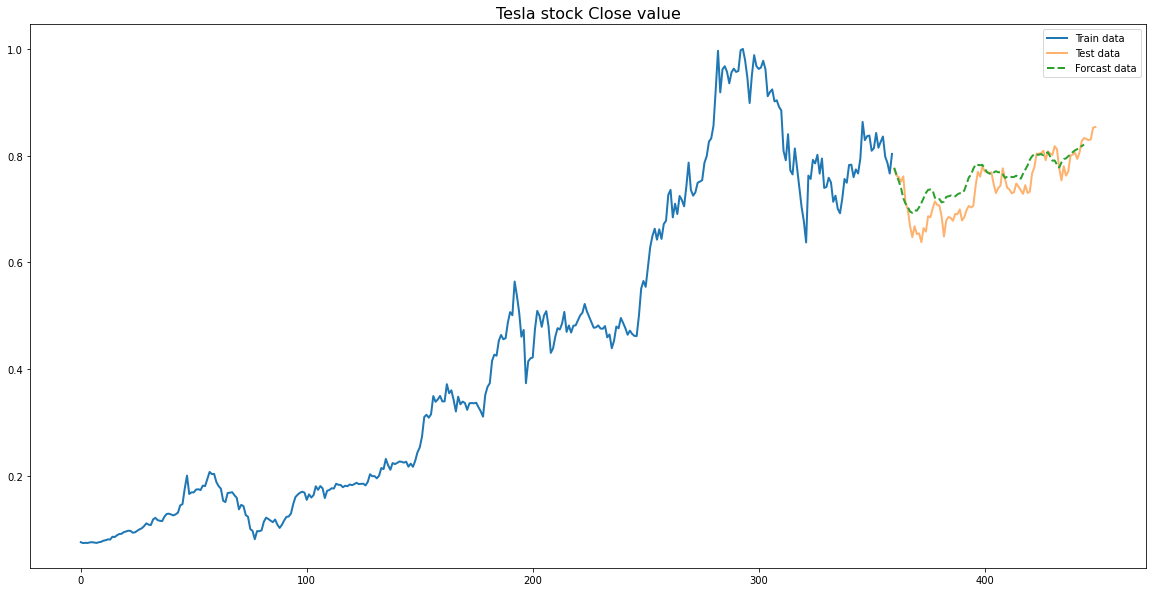

In [21]:
plt.figure(figsize=(20,10))
plt.title('Tesla stock Close value', size=16)
plt.plot(t_train, train_data, '-', label='Train data', linewidth=2)
plt.plot(t_test, test_data, label='Test data', linewidth=2, alpha=.6)
plt.plot(t_frc, frc, '--', label='Forcast data', linewidth=2)
plt.legend()
plt.show()

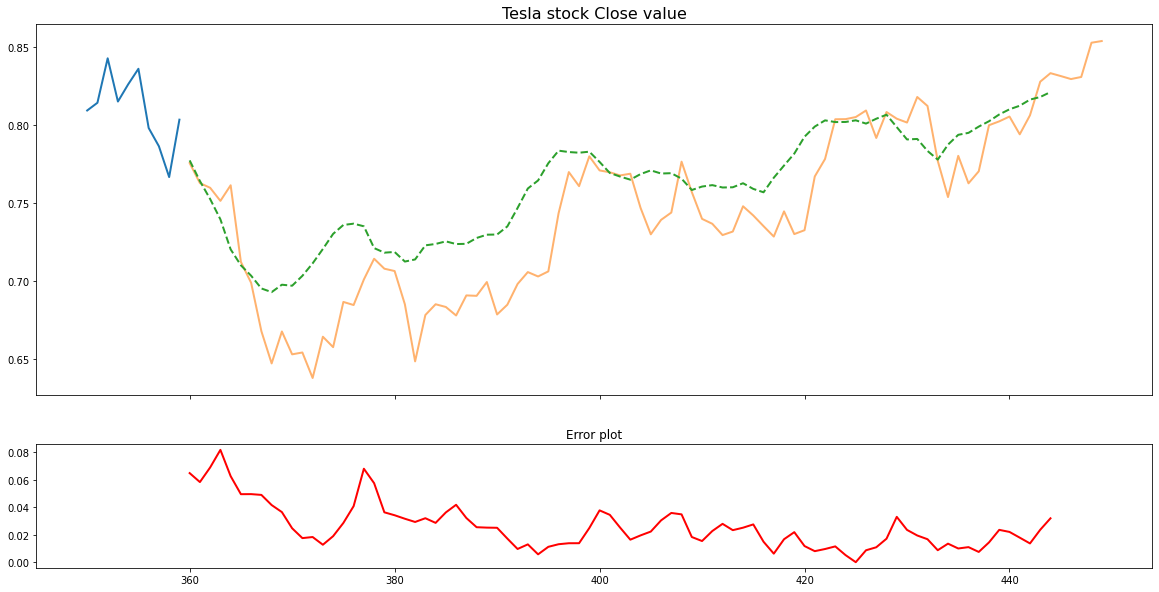

In [22]:
fig, (forc_plot, err_plot) = plt.subplots(2,1, figsize=(20,10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

forc_plot.set_title('Tesla stock Close value', size=16)
forc_plot.plot(t_train[350:], train_data[350:], '-', label='Train data', linewidth=2)
forc_plot.plot(t_test, test_data, label='Test data', linewidth=2, alpha=.6)
forc_plot.plot(t_frc, frc, '--', label='Forcast data', linewidth=2)

err_plot.set_title('Error plot')
err_plot.plot(t_frc, test_err, 'r', linewidth=2)

plt.show()

### 1-100-1 Network

In [23]:
n = Network([1, 100, 1], activation_function=sigmoid)
err = n.fit(train_data, iters=100)

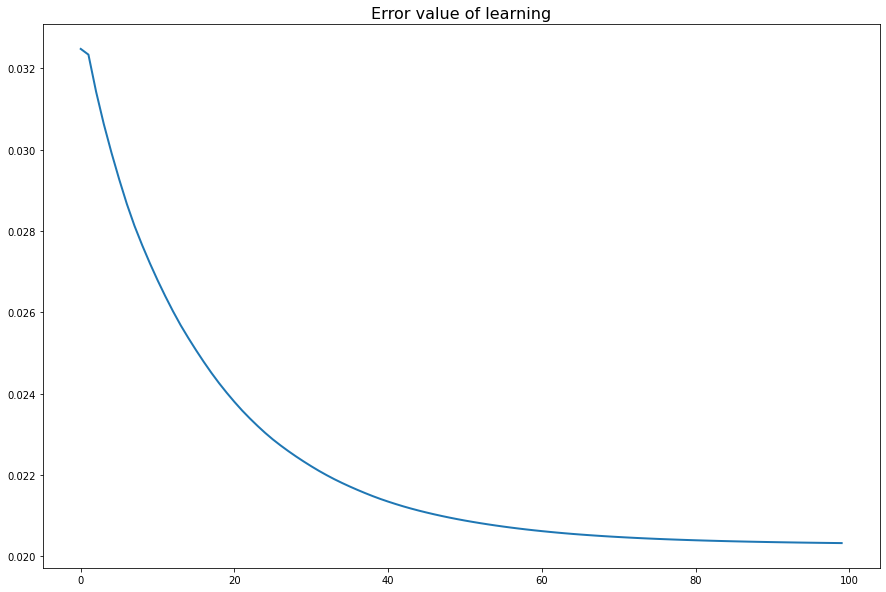

In [24]:
plt.figure(figsize=(15,10))
plt.title('Error value of learning', size=16)
plt.plot(err, linewidth=2)
plt.show()

In [25]:
(frc, test_err) = n.test(test_data)
print(np.average(test_err))

0.02004124971039308


In [26]:
t_train = [ i for i in range(seg) ]
t_test = [ i for i in range(seg, seg+len(test_data))]
t_frc = [ i for i in range(seg, seg+len(frc))]

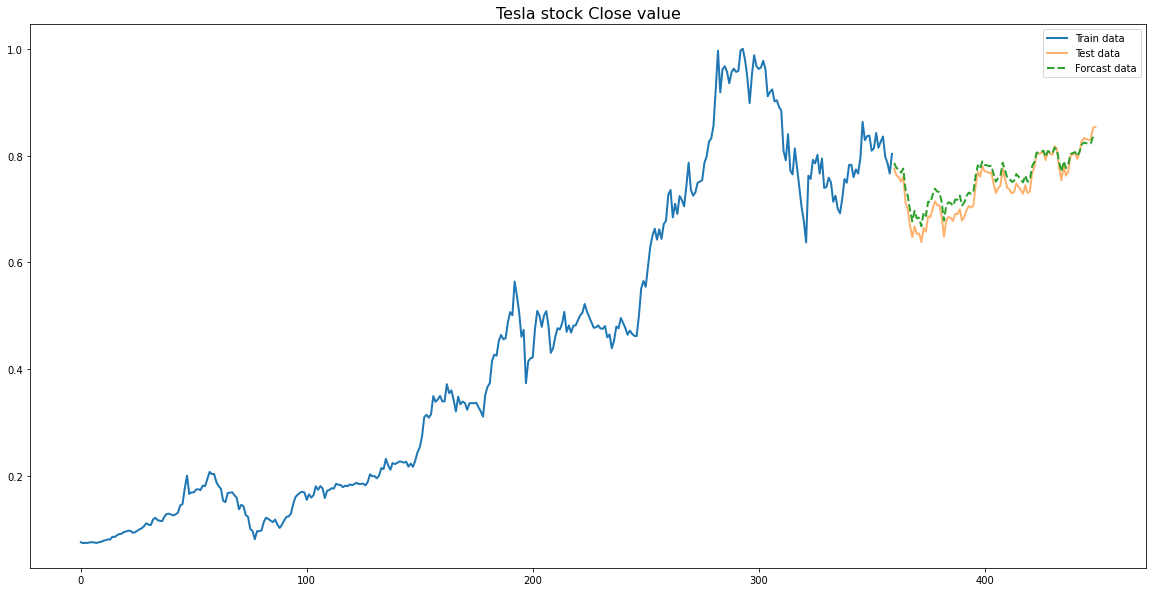

In [27]:
plt.figure(figsize=(20,10))
plt.title('Tesla stock Close value', size=16)
plt.plot(t_train, train_data, '-', label='Train data', linewidth=2)
plt.plot(t_test, test_data, label='Test data', linewidth=2, alpha=.6)
plt.plot(t_frc, frc, '--', label='Forcast data', linewidth=2)
plt.legend()
plt.show()

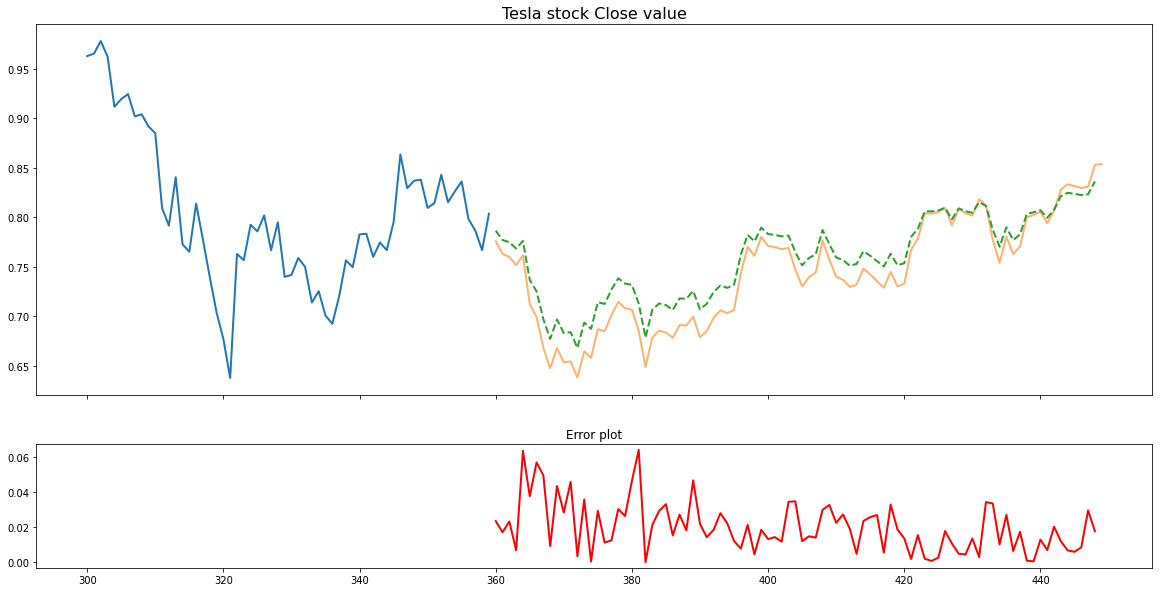

In [28]:
fig, (forc_plot, err_plot) = plt.subplots(2,1, figsize=(20,10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

forc_plot.set_title('Tesla stock Close value', size=16)
forc_plot.plot(t_train[300:], train_data[300:], '-', label='Train data', linewidth=2)
forc_plot.plot(t_test, test_data, label='Test data', linewidth=2, alpha=.6)
forc_plot.plot(t_frc, frc, '--', label='Forcast data', linewidth=2)

err_plot.set_title('Error plot')
err_plot.plot(t_frc, test_err, 'r', linewidth=2)

plt.show()